In [24]:
import pandas as pd
import copy
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# TODOs

## Partner

Check if this is still relevant: 
- <span style="color:red">BUG: more wins than games for (probably) games with 3rd player</span>


- specify when 3 ppl played together
-> re-structure probably: build df iteratively 

## Nemesis

- handle case: muliple opps have same winrate against player

## Misc

- <span style="color:orange">IMPORTANT: handle draws: currently each game and win is counted -> draws count as loss against opponent and negatively impact overall winrate</span>
- <span style="color:orange">rankings: how to display them since number of teams changes depending on date -> eg 3rd out of 4 will look pretty "good" on the graph -> ask GPT?</span>

## Getroffene Cups

- implementieren (in winrate funciton)
- tests schreiben: 
    - stimmt teamcups abhängig von winning team
    - auch mit verlängerung

In [4]:
spiele = pd.read_excel('Spiele.xlsx')
plätze = pd.read_excel('Platzierungen.xlsx')

spiele.fillna(value="", inplace = True)
plätze.fillna(value="", inplace = True)

# rename columns
spiele = spiele.rename(columns = {'Player 1': 'p1', 'Player 2': 'p2', 'Player 3': 'p3', 'Player 4': 'p4', 
                                  'Player 5': 'p5', 'Player 6': 'p6', 'Teamname 1': 'tname1', 'Teamname 2': 'tname2',
                                 'Datum': 'datum', 'W/L Team 1': 'WLt1', 'W/L Team 2': 'WLt2', 'Becher übrig': 'becher',
                                 'Trickshot': 'trickshot', 'Fenster Team': 'fenster', 'Verlängerung': 'verl',
                                 'Becher P1': 'p1Becher', 'Becher P2': 'p2Becher', 'Becher P3': 'p3Becher', 
                                 'Becher T1': 't1Becher', 'Becher P4': 'p4Becher', 'Becher P5': 'p5Becher',
                                  'Becher P6': 'p6Becher', 'Becher T2': 't2Becher', '1v1': '1v1', 
                                  'X_Runden Regel': '5called', 'Eigentore': 'Eigentore'})

# Apply str.strip() to remove trailing spaces from each cell
spiele = spiele.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# define player columns for spiele file
player_cols_spiele  = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6']
# define player columns for plätze file
player_cols_plätze = ['Player 1', 'Player 2', 'Player 3']

# define all player(names)
players = pd.unique(spiele[player_cols_spiele].values.flatten())
players = players.tolist()
# remove empty name
players = [value for value in players if value]
# sort alphabetically
players.sort()

In [5]:
# make sure either both teams lost (X Runden gecalled) or exactly one team lost and excatly one team won
rule = spiele.apply(lambda row: (row['WLt1'], row['WLt2']) in [(0, 1), (1, 0), (0, 0)], axis=1)

if rule.all():
    print("Fine")
else:
    print('Fehler')


Fine


In [6]:
players

['Aaron',
 'Alina',
 'André',
 'Basti',
 'Chris',
 'Cuba',
 'Daisy',
 'Eggi',
 'Emilio',
 'Friedrich',
 'Gina',
 'Hannes',
 'Henny',
 'Jonte',
 'Konni',
 'Konrad',
 'Leon',
 'Lin',
 'Lorenz',
 'Luca',
 'Marian',
 'Marie',
 'Max',
 'Merlin',
 'Michi',
 'Moritz',
 'Mümmel',
 'Nikita',
 'Nora',
 'Ole',
 'Olek',
 'Phia',
 'Philipp',
 'Richard',
 'Tabea',
 'Timo',
 'Tobi',
 'Valdemar',
 'Verena',
 'Vincent',
 'Zoë']

In [7]:
spiele

,p1,p2,p3,p4,p5,p6,tname1,tname2,datum,WLt1,...,p2Becher,p3Becher,t1Becher,p4Becher,p5Becher,p6Becher,t2Becher,1v1,X-Runden Regel,Eigentore
0,Basti,Valdemar,,Emilio,Philipp,,Einmal mit und einmal ohne Socken,Saufomat,2021-11-26,0,...,,,,,,,,,,
1,Phia,Friedrich,,André,Timo,,Team Pferd *hüüh*,Team Samenlando,2021-11-26,1,...,,,,,,,,,,
2,Phia,Friedrich,,Basti,Valdemar,,Team Pferd *hüüh*,Einmal mit und einmal ohne Socken,2021-11-26,1,...,,,,,,,,,,
3,Emilio,Philipp,,André,Timo,,Saufomat,Team Samenlando,2021-11-26,1,...,,,,,,,,,,
4,Emilio,Philipp,,Phia,Friedrich,,Saufomat,Team Pferd *hüüh*,2021-11-26,0,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,Phia,André,,Philipp,Valdemar,,Pieps ÖHH & KraKraKra,Borosboiiis,2024-05-26,1,...,3.0,,6.0,2.0,2.0,,4.0,,,
228,Phia,Chris,,André,Marian,,DD-Detlef und Doris,Geckabor Gangster,2024-05-26,0,...,2.0,,3.0,3.0,3.0,,6.0,,,
229,Emilio,Valdemar,,Phia,Chris,,FDP Ferbrecher,DD-Detlef und Doris,2024-05-26,1,...,1.0,,6.0,2.0,0.0,,2.0,,,
230,André,Marian,,Emilio,Valdemar,,Geckabor Gangster,FDP Ferbrecher,2024-05-26,0,...,4.0,,6.0,4.0,5.0,,9.0,,,


In [8]:
# *args adds as many optional arguments as desired
def winrate(player, *args):
    if args:
        # output should not be printed
        output = 0
    else:
        # output should be printed
        output = 1
    df = spiele.copy(deep=True)
    pattern = rf'\b{player}\b'
    df = df[df[player_cols_spiele].apply(lambda row: row.str.contains(pattern).any(), axis=1)].reset_index(drop=True)
    
    team = -1
    games = 0
    wins = 0
    partner = {elem: [0, 0] for elem in players}
    # opponents: 2nd value = wins AGAINST opponent, 3rd value = winrate AGAINST opponent
    opponents = {elem: [0, 0] for elem in players}
    player_number = 'p0'
    
    for i in range(len(df)):
        partner1, partner2 = '', ''
        
        if df.loc[i, 'p1'] == player:
            player_number = 'p1'
            team = 1
            partner1, partner2 = df.loc[i, 'p2'], df.loc[i, 'p3']
            opponent1, opponent2, opponent3, = df.loc[i, 'p4'], df.loc[i, 'p5'], df.loc[i, 'p6']
        elif df.loc[i, 'p2'] == player:
            player_number = 'p2'
            team = 1
            partner1, partner2 = df.loc[i, 'p1'], df.loc[i, 'p3']
            opponent1, opponent2, opponent3, = df.loc[i, 'p4'], df.loc[i, 'p5'], df.loc[i, 'p6']
        elif df.loc[i, 'p3'] == player:
            player_number = 'p3'
            team = 1
            partner1, partner2 = df.loc[i, 'p1'], df.loc[i, 'p2']
            opponent1, opponent2, opponent3, = df.loc[i, 'p4'], df.loc[i, 'p5'], df.loc[i, 'p6']
        elif df.loc[i, 'p4'] == player:
            player_number = 'p4'
            team = 2
            partner1, partner2 = df.loc[i, 'p5'], df.loc[i, 'p6']
            opponent1, opponent2, opponent3, = df.loc[i, 'p1'], df.loc[i, 'p2'], df.loc[i, 'p3']
        elif df.loc[i, 'p5'] == player:
            player_number = 'p5'
            team = 2
            partner1, partner2 = df.loc[i, 'p4'], df.loc[i, 'p6']
            opponent1, opponent2, opponent3, = df.loc[i, 'p1'], df.loc[i, 'p2'], df.loc[i, 'p3']
        elif df.loc[i, 'p6'] == player:
            player_number = 'p6'
            team = 2
            partner1, partner2 = df.loc[i, 'p4'], df.loc[i, 'p5']
            opponent1, opponent2, opponent3, = df.loc[i, 'p1'], df.loc[i, 'p2'], df.loc[i, 'p3']
        else:
            print(f"Player {player} not found in row {i}")
            continue
        
        if partner1:
            partner[partner1][0] += 1
        if partner2:
            partner[partner2][0] += 1
        # add 3 player teams (don't know how yet)
        #if partner1 & partner2:
        #    partner[partner1 + "&"+ partner2][0] = 1
        
        if opponent1:
            opponents[opponent1][0] += 1
        if opponent2:
            opponents[opponent2][0] += 1
        if opponent3:
            opponents[opponent3][0] += 1
        
        games += 1
        if team == 1:
            current_win = df.loc[i, 'WLt1']
        else:
            current_win = df.loc[i, 'WLt2']
        
        if current_win:
            wins += 1
            if partner1:
                partner[partner1][1] += 1
            if partner2:
                partner[partner2][1] += 1
            if opponent1:
                opponents[opponent1][1] += 1
            if opponent2:
                opponents[opponent2][1] += 1
            if opponent3:
                opponents[opponent3][1] += 1
            
    
    winrate = wins / games * 100
    
    for elem in partner:
        games_tmp = partner[elem][0]
        wins_tmp = partner[elem][1]
        if games_tmp != 0:
            winrate_tmp = wins_tmp / games_tmp
        else:
            winrate_tmp = 0
        partner[elem].append(winrate_tmp)
        
    for elem in opponents:
        games_tmp = opponents[elem][0]
        wins_tmp = opponents[elem][1]
        if games_tmp != 0:
            winrate_tmp = wins_tmp / games_tmp
        else:
            winrate_tmp = 0
        opponents[elem].append(winrate_tmp)
    
    # turn partner into df
    df_partner = pd.DataFrame.from_dict(partner, orient = 'index')
    df_partner.columns = ['Games', 'Wins', 'Winrate']
    df_partner.reset_index(inplace = True)
    df_partner.rename(columns={'index': 'Name'}, inplace = True)
    df_partner.sort_values('Winrate', ascending=False, inplace = True)
    # turn opp into df
    df_opponents = pd.DataFrame.from_dict(opponents, orient = 'index')
    df_opponents.columns = ['Games', 'Wins', 'Winrate']
    df_opponents.reset_index(inplace = True)
    df_opponents.rename(columns={'index': 'Name'}, inplace = True)
    df_opponents.sort_values('Winrate', ascending=True, inplace = True)
    
    # only print stuff if no optional args are given
    if output == 1:
        # print output
        print(f'{player}:')
        print(f'Total games: {games}')
        print(f'Winrate: {winrate:.2f}%')
        print('----------------------------------------')   
    return df_partner, df_opponents

In [9]:
def total_games(player):
    df = spiele.copy(deep=True)
    pattern = rf'\b{player}\b'
    df = df[df[player_cols_spiele].apply(lambda row: row.str.contains(pattern).any(), axis=1)].reset_index(drop=True)
    
    return len(df)

In [10]:
phia_partner, phia_opp = winrate('Phia')

Phia:
Total games: 120
Winrate: 53.33%
----------------------------------------


In [11]:
for elem in players:
    _, _ = winrate(elem)

Aaron:
Total games: 21
Winrate: 47.62%
----------------------------------------
Alina:
Total games: 3
Winrate: 66.67%
----------------------------------------
André:
Total games: 118
Winrate: 53.39%
----------------------------------------
Basti:
Total games: 8
Winrate: 25.00%
----------------------------------------
Chris:
Total games: 87
Winrate: 47.13%
----------------------------------------
Cuba:
Total games: 3
Winrate: 0.00%
----------------------------------------
Daisy:
Total games: 70
Winrate: 37.14%
----------------------------------------
Eggi:
Total games: 6
Winrate: 16.67%
----------------------------------------
Emilio:
Total games: 124
Winrate: 53.23%
----------------------------------------
Friedrich:
Total games: 18
Winrate: 50.00%
----------------------------------------
Gina:
Total games: 7
Winrate: 28.57%
----------------------------------------
Hannes:
Total games: 3
Winrate: 0.00%
----------------------------------------
Henny:
Total games: 3
Winrate: 100.00%
----

In [12]:
def fenster_winrate():
    df = spiele.copy(deep=True)
    df = df[df['fenster'] == 1]
    # since we made sure that team 1 is always fenster, we can just sum up the wins of team1 and divide by the total number of games which have a value in fenster
    print(sum(df['WLt1'])/len(df))
    return

In [13]:
fenster_winrate()

0.5192307692307693


In [14]:
_, a_o = winrate('Alina', '1#')
min_games = 3
a_o['Games'].max()

1

In [258]:

a_p.drop(a_p[a_p.Games < min_games].index, inplace = True)
a_p.sort_values('Winrate', ascending=True, inplace = True)
a_p.reset_index(drop=True, inplace = True)
a_p

,Name,Games,Wins,Winrate
0,Merlin,3,2,0.666667
1,Lorenz,3,2,0.666667


In [15]:
# min_games refers to the minimuim number of games AGAINST a specific opponent
# *args adds as many optional arguments as desired
def nemesis(player, min_games, *args):
    if args:
        # output should not be printed
        output = 0
    else:
        # output should be printed
        output = 1
    _, opp = winrate(player, 'no_output')
    if opp['Games'].max() < min_games:
        print(f'{player} does not have sufficient games.')
        return
    else:
        try:
            opp.drop(opp[opp.Games < min_games].index, inplace = True)
            opp.reset_index(drop=True, inplace = True)
            opp.sort_values('Winrate', ascending=True, inplace = True)
            name = opp.loc[0, 'Name']
            winrate_opp = opp.loc[0, 'Winrate']
            games = opp.loc[0, 'Games']
            if output == 1:
                print(f'{player}\'s Nemesis: {name} with a winrate of {winrate_opp} over {games} Games.')
        except KeyError as e:
            raise Exception(f'Player {player} has too few games (min_games: {min_games}) probably? {opp}') from e
        
    return opp

In [16]:
def ultimate_nemesis(min_games):
    min_games = min_games
    count = {elem: 0 for elem in players}
    for elem in players:
        opp = nemesis(elem, min_games, 'no_output')
        if isinstance(opp, pd.DataFrame):
            ult = opp.loc[0, 'Name']
            count[ult] += 1
        else:
            print(f'Opp was not a df, instead it is ', type(opp), opp)
    return count 

In [309]:
for elem in players: 
    print(f'{elem}: ', total_games(elem))

Aaron:  21
Alina:  3
André:  118
Basti:  8
Chris:  87
Cuba:  3
Daisy:  70
Eggi:  6
Emilio:  124
Friedrich:  18
Gina:  7
Hannes:  3
Henny:  3
Jonte:  4
Konni:  3
Konrad:  3
Leon:  6
Lin:  3
Lorenz:  6
Luca:  16
Marian:  105
Marie:  16
Max:  6
Merlin:  42
Michi:  4
Moritz:  3
Mümmel:  19
Nikita:  5
Nora:  12
Ole:  7
Olek:  6
Phia:  120
Philipp:  28
Richard:  3
Tabea:  3
Timo:  2
Tobi:  3
Valdemar:  119
Verena:  11
Vincent:  4
Zoë:  4


In [17]:
ultimate_nemesis(10)

Aaron does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Alina does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Basti does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Cuba does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Eggi does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Friedrich does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Gina does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Hannes does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Henny does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Jonte does not have sufficient games.
Opp was not a df, instead it is  <class 'NoneType'> None
Konni does not have sufficient games.
Opp was no

{'Aaron': 0,
 'Alina': 0,
 'André': 0,
 'Basti': 0,
 'Chris': 2,
 'Cuba': 0,
 'Daisy': 0,
 'Eggi': 0,
 'Emilio': 3,
 'Friedrich': 0,
 'Gina': 0,
 'Hannes': 0,
 'Henny': 0,
 'Jonte': 0,
 'Konni': 0,
 'Konrad': 0,
 'Leon': 0,
 'Lin': 0,
 'Lorenz': 0,
 'Luca': 0,
 'Marian': 0,
 'Marie': 0,
 'Max': 0,
 'Merlin': 0,
 'Michi': 0,
 'Moritz': 0,
 'Mümmel': 0,
 'Nikita': 0,
 'Nora': 0,
 'Ole': 0,
 'Olek': 0,
 'Phia': 0,
 'Philipp': 0,
 'Richard': 0,
 'Tabea': 0,
 'Timo': 0,
 'Tobi': 0,
 'Valdemar': 3,
 'Verena': 0,
 'Vincent': 0,
 'Zoë': 0}

# Ranks

## Lineplot

In [44]:
def ranks(player):
    df = plätze.copy(deep=True)
    pattern = rf'\b{player}\b'
    df = df[df[player_cols_plätze].apply(lambda row: row.str.contains(pattern).any(), axis=1)].reset_index(drop=True)
    # transform platzierungen into relative ranks
    df['rel_rank'] = (df['Platzierung']-1)/df['Anzahl Teams']
    
    plt.figure(figsize=(14, 10))
    sns.lineplot(data=df, x='Datum', y='rel_rank', marker='o', label='test')

    # Annotation
   # for date, rank in zip(df['Datum'], df['rel_rank']):
   #    plt.annotate(f'{rank:.2f}', (date, rank), textcoords="offset points", xytext=(0,10), ha='center')
    for date, rank, team in zip(df['Datum'], df['rel_rank'], df['Teamname']):
      # plt.annotate(f'{rank:.2f}', (date, rank), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
      plt.gca().annotate(team, (date, rank), textcoords="offset points", xytext=(0,-20), ha='center', fontsize=8, color='gray')
    
    plt.ylim(0.8, -0.1)  # Invert y-axis
    plt.xlabel('Date')
    plt.ylabel('Relative Rank')
    plt.title(f'Rankings Over Time')
    # rotate the x labels by 90 deg for visibilty
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    return #df['rel_rank']

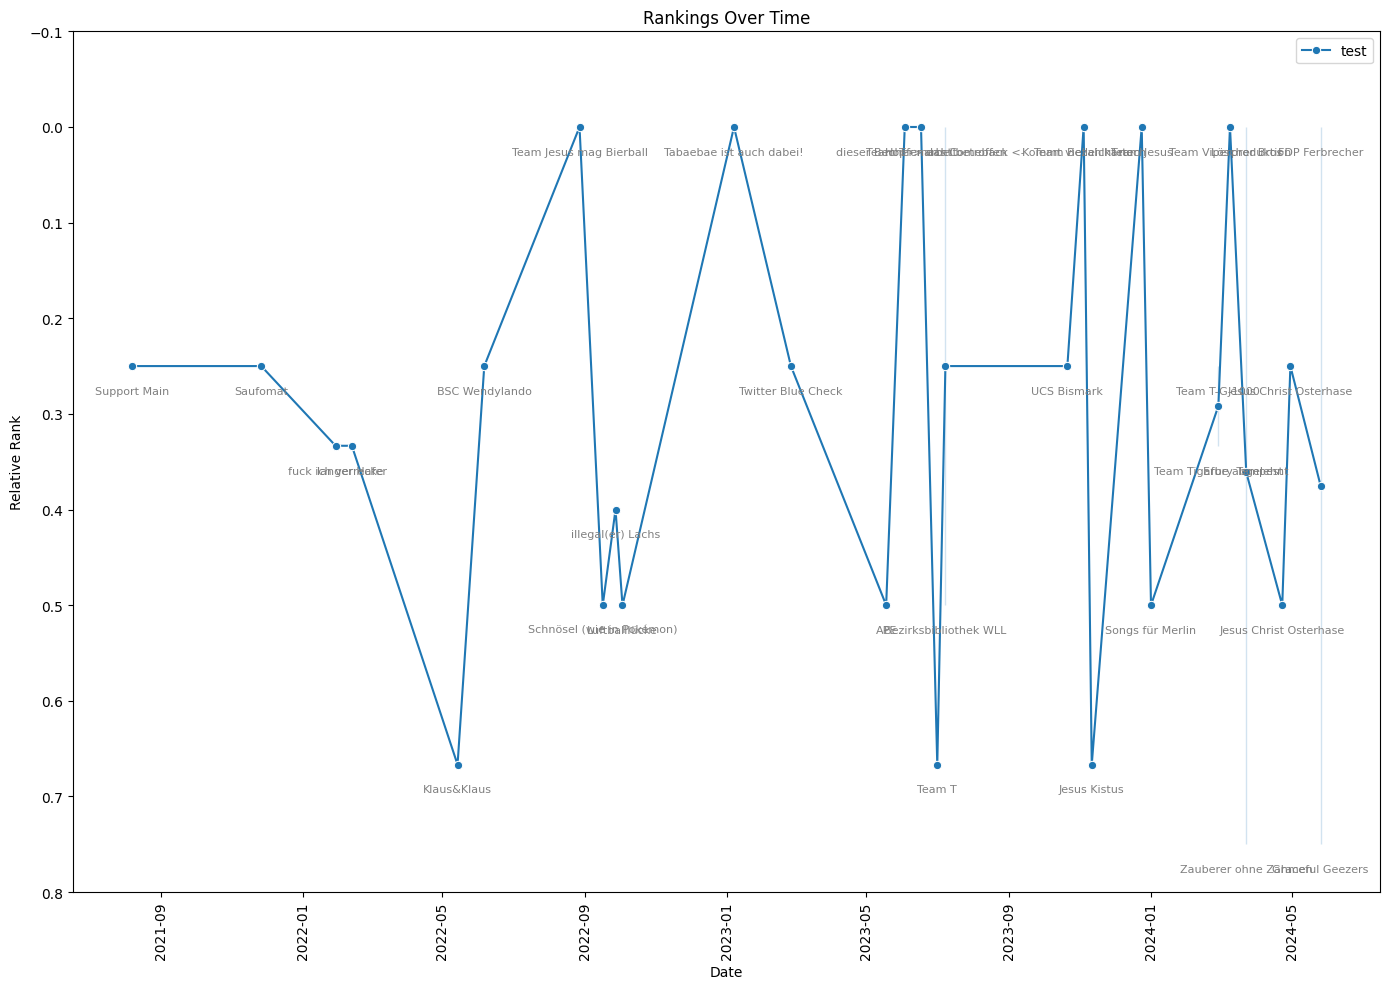

In [45]:
ranks('Emilio')


## Barplot

In [25]:
def ranks_bar(player):
    df = plätze.copy(deep=True)
    pattern = rf'\b{player}\b'
    df = df[df[player_cols_plätze].apply(lambda row: row.str.contains(pattern).any(), axis=1)].reset_index(drop=True)
    # transform platzierungen into relative ranks
    df['rel_rank'] = (df['Platzierung']-1)/df['Anzahl Teams']
    df['Datum'] = pd.to_datetime(df['Datum'])
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x='Datum', y='rel_rank')

    # Annotation
    for index, row in df.iterrows():
        ax.text(row.name, row['rel_rank'], f'{row["rel_rank"]:.2f}', color='black', ha="center", va="bottom")

    # Invert y-axis
    ax.invert_yaxis()

    #plt.ylim(0.8, -0.1)  # Invert y-axis
    plt.xlabel('Date')
    plt.ylabel('Relative Rank')
    plt.title(f'Rankings Over Time')
    #plt.legend()
    plt.show()
    
    return #df['rel_rank']

In [21]:
ranks_bar('Mümmel')

TypeError: 'module' object is not callable

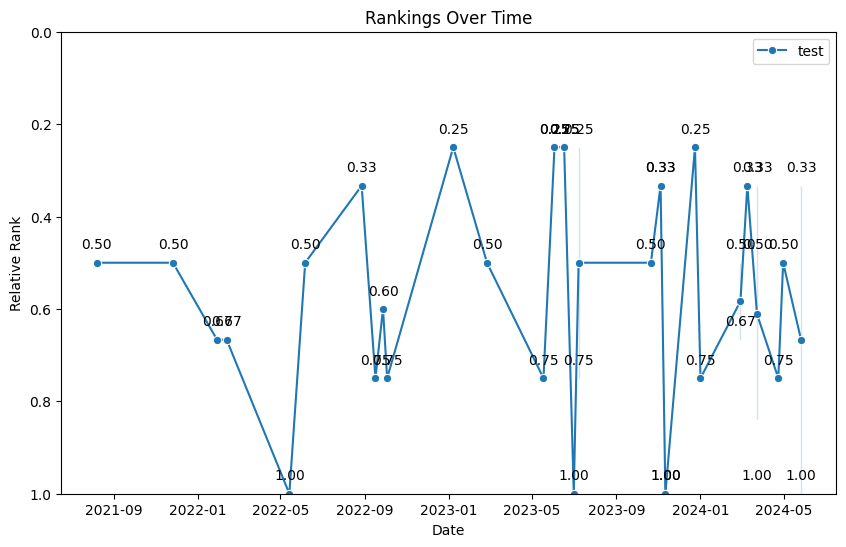

In [59]:
test_platz = platzierungen('Emilio')

# Test Area

### Ranks: lineplot

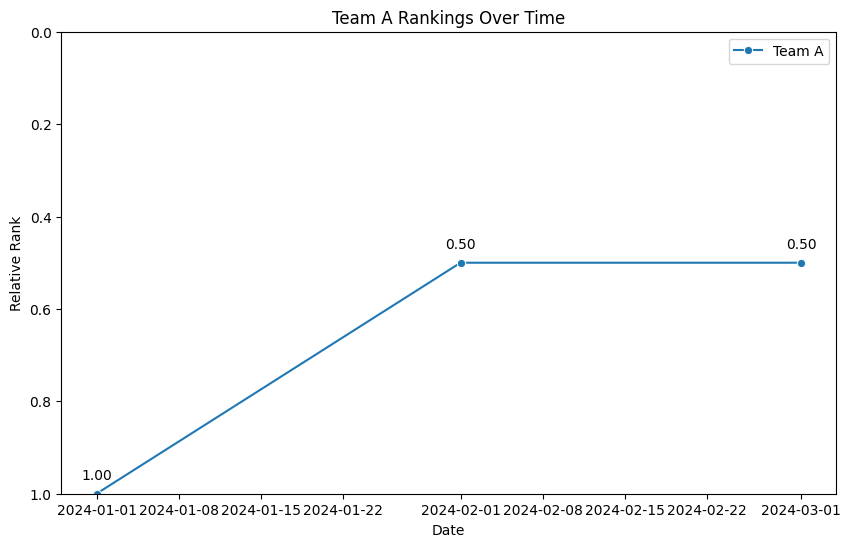

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    "2024-01-01": {"Team A": 3, "Team B": 1, "Team C": 4},
    "2024-02-01": {"Team A": 2, "Team B": 4, "Team C": 3, "Team D": 1},
    "2024-03-01": {"Team A": 1, "Team B": 2}
}

# Select the team to visualize
team_to_plot = "Team A"

# Convert to relative ranks for the selected team
relative_ranks = []
for date, teams in data.items():
    if team_to_plot in teams:
        num_teams = len(teams)
        relative_ranks.append((date, teams[team_to_plot] / num_teams))

# Create a DataFrame for plotting
df = pd.DataFrame(relative_ranks, columns=['Date', 'Relative Rank'])
df['Date'] = pd.to_datetime(df['Date'])

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Date', y='Relative Rank', marker='o', label=team_to_plot)

# Annotate the points
for date, rank in zip(df['Date'], df['Relative Rank']):
    plt.annotate(f'{rank:.2f}', (date, rank), textcoords="offset points", xytext=(0,10), ha='center')

plt.ylim(1, 0)  # Invert y-axis
plt.xlabel('Date')
plt.ylabel('Relative Rank')
plt.title(f'{team_to_plot} Rankings Over Time')
plt.legend()
plt.show()


In [35]:
import plotly.express as px

def ranks_plotly(player):
    df = plätze.copy(deep=True)
    pattern = rf'\b{player}\b'
    df = df[df[player_cols_plätze].apply(lambda row: row.str.contains(pattern).any(), axis=1)].reset_index(drop=True)
    # transform platzierungen into relative ranks
    df['rel_rank'] = (df['Platzierung']-1)/df['Anzahl Teams']
    
    fig = px.line(df, x='Datum', y='rel_rank', hover_data=['Team'], markers=True, title=f'Rankings Over Time for {player}')
    fig.update_layout(yaxis_range=[0.8, -0.1], yaxis_title='Relative Rank', xaxis_title='Date')
    fig.show()
    
    return df['rel_rank']

ModuleNotFoundError: No module named 'plotly'

In [ ]:
ranks_plótly('Emilio')

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def ranks2(player):
    df = plätze.copy(deep=True)
    pattern = rf'\b{player}\b'
    df = df[df[player_cols_plätze].apply(lambda row: row.str.contains(pattern).any(), axis=1)].reset_index(drop=True)
    # transform platzierungen into relative ranks
    df['rel_rank'] = (df['Platzierung']-1)/df['Anzahl Teams']
    df['Datum'] = pd.to_datetime(df['Datum'])
    
    # Add jitter to dates
    np.random.seed(42)  # for reproducibility
    df['jittered_date'] = df['Datum'] + pd.Timedelta(days=np.random.uniform(-0.2, 0.2, len(df)))
    
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df, x='jittered_date', y='rel_rank', marker='o', label=player)

    # Annotation
    for date, rank, team in zip(df['jittered_date'], df['rel_rank'], df['Team']):
        plt.annotate(f'{rank:.2f}', (date, rank), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
        plt.gca().annotate(team, (date, rank), textcoords="offset points", xytext=(0,-20), ha='center', fontsize=8, color='gray')

    plt.ylim(0.8, -0.1)  # Invert y-axis
    plt.xlabel('Date')
    plt.ylabel('Relative Rank')
    plt.title(f'Rankings Over Time for {player}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df['rel_rank']

In [47]:
ranks2('Emilio')

TypeError: Invalid type <class 'numpy.ndarray'>. Must be int or float.

### Ranks: Barplot

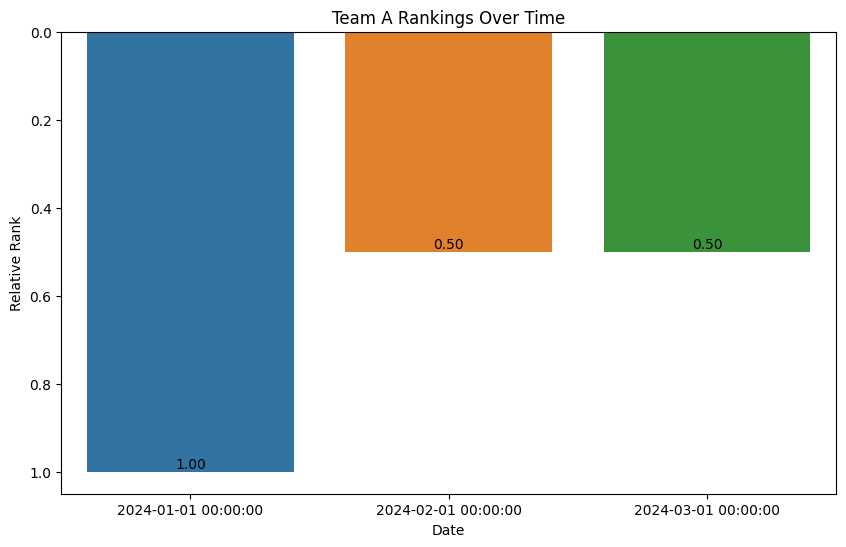

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    "2024-01-01": {"Team A": 3, "Team B": 1, "Team C": 4},
    "2024-02-01": {"Team A": 2, "Team B": 4, "Team C": 3, "Team D": 1},
    "2024-03-01": {"Team A": 1, "Team B": 2}
}

# Select the team to visualize
team_to_plot = "Team A"

# Convert to relative ranks for the selected team
relative_ranks = []
for date, teams in data.items():
    if team_to_plot in teams:
        num_teams = len(teams)
        relative_ranks.append((date, teams[team_to_plot] / num_teams))

# Create a DataFrame for plotting
df = pd.DataFrame(relative_ranks, columns=['Date', 'Relative Rank'])
df['Date'] = pd.to_datetime(df['Date'])

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Date', y='Relative Rank')

# Annotate the bars
for index, row in df.iterrows():
    ax.text(row.name, row['Relative Rank'], f'{row["Relative Rank"]:.2f}', color='black', ha="center", va="bottom")

# Invert y-axis
ax.invert_yaxis()

plt.xlabel('Date')
plt.ylabel('Relative Rank')
plt.title(f'{team_to_plot} Rankings Over Time')

plt.show()


In [22]:
relative_ranks

{'2024-01-01': {'Team A': 1.0,
  'Team B': 0.3333333333333333,
  'Team C': 1.3333333333333333},
 '2024-02-01': {'Team A': 0.5, 'Team B': 1.0, 'Team C': 0.75, 'Team D': 0.25},
 '2024-03-01': {'Team A': 0.5, 'Team B': 1.0}}

Maybe represent teams as dicts of player names?

In [17]:


dict_test = {player: [0, 0] for player in players}
#dict_test['Team1'] = [2, 1]
#dict_test['Team1'][1] += 1

dict_test['Chris'][1] += 1
dict_test

{'Aaron': [0, 0],
 'Alina': [0, 0],
 'André': [0, 0],
 'Basti': [0, 0],
 'Chris': [0, 1],
 'Cuba': [0, 0],
 'Daisy': [0, 0],
 'Eggi': [0, 0],
 'Emilio': [0, 0],
 'Friedrich': [0, 0],
 'Gina': [0, 0],
 'Hannes': [0, 0],
 'Henny': [0, 0],
 'Jonte': [0, 0],
 'Konni': [0, 0],
 'Konrad': [0, 0],
 'Leon': [0, 0],
 'Lin': [0, 0],
 'Lorenz': [0, 0],
 'Luca': [0, 0],
 'Marian': [0, 0],
 'Marie': [0, 0],
 'Max': [0, 0],
 'Merlin': [0, 0],
 'Michi': [0, 0],
 'Moritz': [0, 0],
 'Mümmel': [0, 0],
 'Nikita': [0, 0],
 'Nora': [0, 0],
 'Ole': [0, 0],
 'Olek': [0, 0],
 'Phia': [0, 0],
 'Philipp': [0, 0],
 'Richard': [0, 0],
 'Tabea': [0, 0],
 'Timo': [0, 0],
 'Tobi': [0, 0],
 'Valdemar': [0, 0],
 'Verena': [0, 0],
 'Vincent': [0, 0],
 'Zoë': [0, 0]}

In [18]:
test1 = ''
if test1:
    print('hallo')
test2 = "Chris"
if test2:
    print('hallo2')
test_dict = {}
if test1 and test1 in test_dict:
    print('sos')
else: print('sus')

hallo2
sus


In [19]:

#partner_test = pd.DataFrame(partner_andre, columns = ['Name', 'Total Games'])
#partner_test['Wins'] = partner_wins_andre
#partner_test.set_index('Name', inplace = True)

#partner_test.loc['Phia', 'Wins'] = partner_wins_andre['Phia']
#for key in partner_wins_andre:
#    partner_test.loc[key, 'Wins'] = partner_wins_andre[key]
#partner_test['Wins'].fillna(0, inplace = True)
#partner_test['Winrate'] = partner_test['Wins']/partner_test['Total Games']
#partner_test

In [20]:
andre, partner_andre = winrate('André') 
partner_andre.sort_values('Winrate', ascending = False)

NameError: name 'winrate' is not defined

In [ ]:
andre, partner_andre = winrate('André') 
partner_andre

Total games: 118
Winrate André: 53.39%



[('Phia', 24),
 ('Chris', 20),
 ('Valdemar', 16),
 ('Emilio', 16),
 ('Marian', 15),
 ('Luca', 9),
 ('Daisy', 7),
 ('Merlin', 7),
 ('Aaron', 6),
 ('Mümmel', 5),
 ('Michi', 4),
 ('Philipp', 4),
 ('Basti', 3),
 ('Marie', 3),
 ('Henny', 3),
 ('Timo', 2),
 ('Gina', 2)]

In [ ]:
# remove empty string
partner_andre = [x for x in partner_andre if x]
# remove the player themselves
partner_andre = [x for x in partner_andre if x!= 'André']
partner_andre
partners = Counter(partner_andre).most_common()
partners

In [ ]:
# OLD WINRATE
def winrate2(player):
    df = spiele.copy(deep = True)
    # use this pattern to get rid of unwanted whitespaces and to make sure 'Ole' is not found when searching for 'Olek'
    pattern = rf'\b{player}\b'
    # important: reset the index because otherwise it will not start at 0 and the for loop wont work
    # drop = True: don't include the old indexes as a column
    df = df[df[player_cols_spiele].apply(lambda row: row.str.contains(pattern).any(), axis=1)].reset_index(drop=True)
    team = -1
    games = 0
    wins = 0
    partner = []
    player_number = 'p0'
    partner_games = {}
    partner_wins = {}
    partner1 = ''
    partner2 = ''
    for i in range(len(df)):
        if df.loc[i, 'p1'] == player:
            player_number = 'p1'
            team = 1
            # add both other players of team 1 as partners
            partner.append(df.loc[i, 'p2'])
            partner.append(df.loc[i, 'p3'])
            #if df.loc[i, 'p2'] in partner_games
            #partner_games[df.loc[i, 'p2']] += 1
        elif df.loc[i, 'p2'] == player:
            player_number = 'p2'
            team = 1
            # add both other players of team 1 as partners
            partner.append(df.loc[i, 'p1'])
            partner.append(df.loc[i, 'p3'])   
        elif df.loc[i, 'p3'] == player:
            player_number = 'p3'
            team = 1
            # add both other players of team 1 as partners
            partner.append(df.loc[i, 'p1'])
            partner.append(df.loc[i, 'p2'])
        elif df.loc[i, 'p4'] == player:
            player_number = 'p4'
            team = 2
            # add both other players of team 1 as partners
            partner.append(df.loc[i, 'p5'])
            partner.append(df.loc[i, 'p6']) 
        elif df.loc[i, 'p5'] == player:
            player_number = 'p5'
            team = 2
            # add both other players of team 1 as partners
            partner.append(df.loc[i, 'p4'])
            partner.append(df.loc[i, 'p6']) 
        elif df.loc[i, 'p6'] == player:
            player_number = 'p6'
            team = 2
            # add both other players of team 1 as partners
            partner.append(df.loc[i, 'p4'])
            partner.append(df.loc[i, 'p5']) 
        else:
            print("Player {player} not found in row {row}".format(player = player, row = i))
        if team == 1:
            games += 1
            wins = wins + df.loc[i, 'WLt1']
        elif team == 2:
            games += 1
            wins = wins + df.loc[i, 'WLt2']
        else:
            print("Team not set correctly on Player {player} in row {row}".format(player = player, row = i))
    winrate = wins/games*100        
    print('Total games: {games}'.format(games=games))
    print('Winrate {player}: {winrate:.2f}%\n'.format(player=player, winrate=winrate))
    # remove empty string
    partner = [x for x in partner if x]
    # remove the player themselves, maybe not needed anymore
    #partner = [x for x in partner if x!= player]
    # count the occurences of partners and return them sorted by most frequent
    partner_count = Counter(partner).most_common()
    return df, partner_count

In [ ]:
# OLD WINRATE
def winrate3(player):
    df = spiele.copy(deep = True)
    # use this pattern to get rid of unwanted whitespaces and to make sure 'Ole' is not found when searching for 'Olek'
    pattern = rf'\b{player}\b'
    # important: reset the index because otherwise it will not start at 0 and the for loop wont work
    # drop = True: don't include the old indexes as a column
    df = df[df[player_cols_spiele].apply(lambda row: row.str.contains(pattern).any(), axis=1)].reset_index(drop=True)
    team = -1
    games = 0
    wins = 0
    partner = []
    player_number = 'p0'
    partner_games = {}
    partner_wins = {}
    partner1 = ''
    partner2 = ''
    for i in range(len(df)):
        if df.loc[i, 'p1'] == player:
            player_number = 'p1'
            team = 1
            # add both other players of team 1 as partners
            if partner1 != df.loc[i, 'p2']:
                partner1 = df.loc[i, 'p2']
                partner.append(partner1)
                #if partner1 in partner_games:
                #    partner_games[partner1] += 1
                #else: partner_games[partner1] = 1
            if partner2 != df.loc[i, 'p3']:
                partner2 = df.loc[i, 'p3']
                partner.append(partner2)
        elif df.loc[i, 'p2'] == player:
            player_number = 'p2'
            team = 1
            # add both other players of team 1 as partners
            if partner1 != df.loc[i, 'p1']:
                partner1 = df.loc[i, 'p1']
                partner.append(partner1)
            if partner2 != df.loc[i, 'p3']:
                partner2 = df.loc[i, 'p3']
                partner.append(partner2)  
        elif df.loc[i, 'p3'] == player:
            player_number = 'p3'
            team = 1
            # add both other players of team 1 as partners
            if partner1 != df.loc[i, 'p1']:
                partner1 = df.loc[i, 'p1']
                partner.append(partner1)
            if partner2 != df.loc[i, 'p2']:
                partner2 = df.loc[i, 'p2']
                partner.append(partner2)
        elif df.loc[i, 'p4'] == player:
            player_number = 'p4'
            team = 2
            # add both other players of team 1 as partners
            if partner1 != df.loc[i, 'p5']:
                partner1 = df.loc[i, 'p5']
                partner.append(partner1)
            if partner2 != df.loc[i, 'p6']:
                partner2 = df.loc[i, 'p6']
                partner.append(partner2)
        elif df.loc[i, 'p5'] == player:
            player_number = 'p5'
            team = 2
            # add both other players of team 1 as partners
            if partner1 != df.loc[i, 'p4']:
                partner1 = df.loc[i, 'p4']
                partner.append(partner1)
            if partner2 != df.loc[i, 'p6']:
                partner2 = df.loc[i, 'p6']
                partner.append(partner2)
        elif df.loc[i, 'p6'] == player:
            player_number = 'p6'
            team = 2
            # add both other players of team 1 as partners
            if partner1 != df.loc[i, 'p4']:
                partner1 = df.loc[i, 'p4']
                partner.append(partner1)
            if partner2 != df.loc[i, 'p5']:
                partner2 = df.loc[i, 'p5']
                partner.append(partner2)
        else:
            print("Player {player} not found in row {row}".format(player = player, row = i))
        if team == 1:
            games += 1
            current_win = df.loc[i, 'WLt1']
            if current_win:
                wins = wins + 1
                if partner1 in partner_wins:
                    partner_wins[partner1] += 1
                else: partner_wins[partner1] = 1
                if partner2 in partner_games:
                    partner_games[partner2] += 1
                else: partner_games[partner2] = 1
        elif team == 2:
            games += 1
            current_win = df.loc[i, 'WLt2']
            if current_win:
                wins = wins + 1
                if partner1 in partner_wins:
                    partner_wins[partner1] += 1
                else: partner_wins[partner1] = 1
                if partner2 in partner_games:
                    partner_games[partner2] += 1
                else: partner_games[partner2] = 1
        else:
            print("Team not set correctly on Player {player} in row {row}".format(player = player, row = i))
    winrate = wins/games*100        
    print('Total games: {games}'.format(games=games))
    print('Winrate {player}: {winrate:.2f}%\n'.format(player=player, winrate=winrate))
    # remove empty string
    partner = [x for x in partner if x]
    # remove the player themselves, maybe not needed anymore
    #partner = [x for x in partner if x!= player]
    # count the occurences of partners and return them sorted by most frequent
    partner_count = Counter(partner).most_common()
    return df, partner_count, partner_wins

In [ ]:
def winrate4(player):
    df = spiele.copy(deep = True)
    # use this pattern to get rid of unwanted whitespaces and to make sure 'Ole' is not found when searching for 'Olek'
    pattern = rf'\b{player}\b'
    # important: reset the index because otherwise it will not start at 0 and the for loop wont work
    # drop = True: don't include the old indexes as a column
    df = df[df[player_cols_spiele].apply(lambda row: row.str.contains(pattern).any(), axis=1)].reset_index(drop=True)
    team = -1
    games = 0
    wins = 0
    partner = []
    partner = {player: [0, 0] for player in players}
    player_number = 'p0'
#    partner_games = {}
    partner_wins = {}
    partner1 = ''
    partner2 = ''
    for i in range(len(df)):
        if df.loc[i, 'p1'] == player:
            player_number = 'p1'
            team = 1
            # add both other players of team 1 as partners
            if df.loc[i, 'p2']:
                partner1 = df.loc[i, 'p2']
                partner.append(partner1)
                partner[partner1][0] += 1 
                #if partner1 in partner_games:
                #    partner_games[partner1] += 1
                #else: partner_games[partner1] = 1
            if df.loc[i, 'p3']:
                partner2 = df.loc[i, 'p3']
                partner.append(partner2)
                partner[partner2][0] += 1 
        elif df.loc[i, 'p2'] == player:
            player_number = 'p2'
            team = 1
            # add both other players of team 1 as partners
            if df.loc[i, 'p1']:
                partner1 = df.loc[i, 'p1']
                partner.append(partner1)
                partner[partner1][0] += 1 
            if df.loc[i, 'p3']:
                partner2 = df.loc[i, 'p3']
                partner.append(partner2)
                partner[partner2][0] += 1  
        elif df.loc[i, 'p3'] == player:
            player_number = 'p3'
            team = 1
            # add both other players of team 1 as partners
            if df.loc[i, 'p1']:
                partner1 = df.loc[i, 'p1']
                partner.append(partner1)
                partner[partner1][0] += 1 
            if df.loc[i, 'p2']:
                partner2 = df.loc[i, 'p2']
                partner.append(partner2)
                partner[partner2][0] += 1 
        elif df.loc[i, 'p4'] == player:
            player_number = 'p4'
            team = 2
            # add both other players of team 1 as partners
            if df.loc[i, 'p5']:
                partner1 = df.loc[i, 'p5']
                partner.append(partner1)
                partner[partner1][0] += 1 
            if df.loc[i, 'p6']:
                partner2 = df.loc[i, 'p6']
                partner.append(partner2)
                partner[partner2][0] += 1 
        elif df.loc[i, 'p5'] == player:
            player_number = 'p5'
            team = 2
            # add both other players of team 1 as partners
            if df.loc[i, 'p4']:
                partner1 = df.loc[i, 'p4']
                partner.append(partner1)
                partner[partner1][0] += 1 
            if df.loc[i, 'p6']:
                partner2 = df.loc[i, 'p6']
                partner.append(partner2)
                partner[partner2][0] += 1 
        elif df.loc[i, 'p6'] == player:
            player_number = 'p6'
            team = 2
            # add both other players of team 1 as partners
            if df.loc[i, 'p4']:
                partner1 = df.loc[i, 'p4']
                partner.append(partner1)
                partner[partner1][0] += 1 
            if df.loc[i, 'p5']:
                partner2 = df.loc[i, 'p5']
                partner.append(partner2)
                partner[partner2][0] += 1 
        else:
            print("Player {player} not found in row {row}".format(player = player, row = i))
        if team == 1:
            games += 1
            current_win = df.loc[i, 'WLt1']
            if current_win:
                wins = wins + 1
                if partner1:
                    partner[partner1][1] += 1 
                    if partner1 in partner_wins:
                        partner_wins[partner1] += 1
                    else: partner_wins[partner1] = 1
                if partner2:
                    partner[partner2][1] += 1 
                    if partner2 in partner_wins:
                        partner_wins[partner2] += 1
                    else: partner_wins[partner2] = 1
        elif team == 2:
            games += 1
            current_win = df.loc[i, 'WLt2']
            if current_win:
                wins = wins + 1
                if partner1:  
                    partner[partner1][1] += 1 
                    if partner1 in partner_wins:
                        partner_wins[partner1] += 1
                    else: partner_wins[partner1] = 1
                if partner2:
                    partner[partner2][1] += 1 
                    if partner2 in partner_wins:
                        partner_wins[partner2] += 1
                    else: partner_wins[partner2] = 1
        else:
            print("Team not set correctly on Player {player} in row {row}".format(player = player, row = i))
    winrate = wins/games*100        
    print('Total games: {games}'.format(games=games))
    print('Winrate {player}: {winrate:.2f}%\n'.format(player=player, winrate=winrate))
    # remove empty string
    partner = [x for x in partner if x]
    # remove the player themselves, maybe not needed anymore
    #partner = [x for x in partner if x!= player]
    # count the occurences of partners and return them sorted by most frequent
    partner_count = Counter(partner).most_common()
    # pack the partner names & number of total games into a df 
    partner_df = pd.DataFrame(partner_count, columns = ['Name', 'Total Games'])
    # make the names the index
    partner_df.set_index('Name', inplace = True)
    # add the parter wins
    for key in partner_wins:
        partner_df.loc[key, 'Wins'] = partner_wins[key]
    partner_df['Wins'].fillna(0, inplace = True)
    partner_df['Winrate'] = partner_df['Wins']/partner_df['Total Games']
    # add winrate to partner
    for elem in partner:
        games_tmp = partner[elem][0]
        wins_tmp = partner[elem][1]
        # handle division by 0
        if games_tmp !=0:
            winrate_tmp = wins_tmp / games_tmp
        else: 
            winrate_tmp = 0
        partner[elem].append(winrate_tmp)
    return partner_df, partner